# Excercise 3

## Load the data

In [1]:
def load_data(pickle_file):
    import pickle

    with open(pickle_file, 'rb') as f:
        return pickle.load(f)

data = load_data('partial_notMNIST.pickle')
train_dataset = data['train_dataset']
train_labels = data['train_labels']
test_dataset = data['test_dataset']
test_labels = data['test_labels']
valid_dataset = data['valid_dataset']
valid_labels = data['valid_labels']

## Plot the images

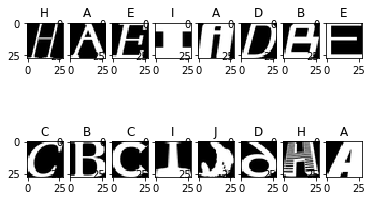

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import random

def label_to_char(one_hot):
    return "ABCDEFGHIJ"[one_hot]

n = 16
rows = 2
for i in range(1,1+n):
    image_to_show = random.randint(0,len(train_dataset))
    plt.subplot(rows,n/rows,i)
    plt.imshow(train_dataset[image_to_show], cmap="gray")
    plt.title(label_to_char(train_labels[image_to_show]))


## Helper Functions

In [3]:
image_size = 28
num_labels = 10

# Convert 2 to [0, 0, 1, 0, 0, 0, 0, 0, 0, 0]
def to_one_hot(labels):
    return (np.arange(num_labels) == labels[:,None]).astype(np.float32)

def from_one_hot(labels):
    return np.argmax(labels,1)

def reformat(dataset, labels):
  dataset = dataset.reshape((-1, image_size * image_size)).astype(np.float32)
  labels = to_one_hot(labels)
  return dataset, labels

def print_row(cols, max_length=20):
    col_width = max_length
    print("".join(str(word).ljust(col_width) for word in cols))

## Simple classification pipeline

In [4]:
import numpy as np

def accuracy(predictions, labels):
    return (np.sum(np.array(predictions) == np.array(labels))
          / len(predictions))

def evaluate_classifier(classifier):  
    # Train
    classifier.fit(train_dataset, train_labels)
    
    # Evaluate
    predictions = classifier.predict(test_dataset)

    print("Test accuracy: %s" % accuracy(predictions, test_labels))
  



## Hands-On: Our first Neural Network

Now it's time to create your first Neural Network. 

**Hints**:

You can use the following functions:

    tf.matmul
    tf.nn.softmax
    tf.nn.softmax_cross_entropy_with_logits


In [25]:
import tensorflow as tf

class TensorNeuralNetwork:
    def __init__(self):
        self.num_steps = 100
        self.num_relu = 1024
        self.image_size = 28
    
    def fit(self, train_data, train_labels):
        tf_train_dataset = tf.placeholder(tf.float32,
                                        shape=(len(train_data), self.image_size * self.image_size))
        tf_train_labels = tf.placeholder(tf.float32, shape=(len(train_data), num_labels))

        # Variables.
        weights_1 = tf.Variable(tf.truncated_normal([self.image_size * self.image_size, self.num_relu]))
        biases_1 = tf.Variable(tf.zeros([self.num_relu]))

        hidden_input = tf.matmul(tf_train_dataset, weights_1) + biases_1
        hidden_output = tf.nn.relu(hidden_input)

        weights_2 = tf.Variable(tf.truncated_normal([self.num_relu, num_labels]))
        biases_2 = tf.Variable(tf.zeros([num_labels]))

        # Training computation.
        logits = tf.matmul(hidden_output, weights_2) + biases_2

        # Loss to optimize
        loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=tf_train_labels))

        # Optimizer.
        optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)

        # Predictions for the training, validation, and test data.
        train_prediction = tf.nn.softmax(logits)
        
        dataset, labels = reformat(train_dataset, train_labels)

        with tf.Session() as session:
          tf.global_variables_initializer().run()
          print_row(['Step', 'Loss', 'Acc-Train'])
          for step in range(self.num_steps):
            feed_dict = {tf_train_dataset : dataset, tf_train_labels : labels}

            _, l, predictions, w1, b1, w2, b2 = session.run(
                [
                    optimizer, loss, train_prediction, 
                    weights_1, biases_1, weights_2, biases_2
                ], 
                feed_dict=feed_dict
            )

            if (step % 10 == 0):
              test_acc = accuracy(from_one_hot(predictions), from_one_hot(labels))

              print_row([step, l, test_acc])
        
        self.weights_1 = w1
        self.biases_1 = b1
        self.weights_2 = w2
        self.biases_2 = b2
        
    def predict(self, data):
        data,_ = reformat(data, np.arange(10))
        
        weights_1 = tf.constant(self.weights_1)
        biases_1 = tf.constant(self.biases_1)
        weights_2 = tf.constant(self.weights_2)
        biases_2 = tf.constant(self.biases_2)
        tfdata = tf.constant(data)

        hidden_input = tf.matmul(tfdata, weights_1) + biases_1
        hidden_output = tf.nn.relu(hidden_input)

        logits = tf.matmul(hidden_output, weights_2) + biases_2

        prediction = tf.nn.softmax(logits)
            
        with tf.Session() as session:
            tf.global_variables_initializer().run()
            predictions, _ = session.run([prediction, logits])
            return from_one_hot(predictions)


In [26]:
evaluate_classifier(TensorNeuralNetwork())

Step                Loss                Acc-Train           
0                   322.157             0.0867              
10                  58.1998             0.805               
20                  29.1727             0.8251              
30                  25.757              0.8366              
40                  15.4144             0.8458              
50                  36.2802             0.8123              
60                  9.24391             0.8698              
70                  7.24127             0.8778              
80                  4.86948             0.8969              
90                  33.5276             0.8046              
Test accuracy: 0.85
